In [35]:
import os
from dotenv import load_dotenv
from datetime import datetime

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

In [36]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [37]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

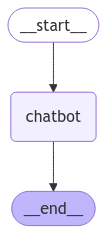

In [38]:
workflow=StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [39]:
input={"messages":["hi, my name is sunny"]}

app.invoke(input)

{'messages': [HumanMessage(content='hi, my name is sunny', additional_kwargs={}, response_metadata={}, id='89b0c238-1b96-43a2-b3b5-ee7144d3b075'),
  AIMessage(content="Hi Sunny, it's nice to meet you! How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-654e5e3e-0d0e-4d4a-bc98-90b542c95dff-0', usage_metadata={'input_tokens': 6, 'output_tokens': 19, 'total_tokens': 25, 'input_token_details': {'cache_read': 0}})]}

In [40]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content="Hi Sunny! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d9e7e35d-b745-4e58-ab9c-0336e70dac6d-0', usage_metadata={'input_tokens': 6, 'output_tokens': 19, 'total_tokens': 25, 'input_token_details': {'cache_read': 0}})]}




In [41]:
@tool
def search(query: str):
    """this is my custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

search.invoke("what is a temprature in sf?")

"It's 60 degrees and foggy."

In [42]:
search.invoke("what is a weather in india?")

"It's 90 degrees and sunny."

In [10]:
search

StructuredTool(name='search', description='this is my custom tool.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x12824d440>)

In [43]:
tools=[search]

tool_node=ToolNode(tools)

llm_with_tool=llm.bind_tools(tools)

def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

response=call_model({"messages": ["hi how are you?"]})

response

{'messages': [AIMessage(content='I am doing well, thank you for asking. How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-0c99bd5d-a49f-41dc-a451-400d85c5a9bf-0', usage_metadata={'input_tokens': 14, 'output_tokens': 18, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}})]}

In [20]:
messages = response['messages']

last_message=messages[-1]

last_message.tool_calls

[]

In [21]:
response=call_model({"messages": ["what is a weather in India?"]})

response


{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in India"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-b86ad9d5-60d9-4309-bc9c-b13576d47b88-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in India'}, 'id': '681db34e-6587-4a34-b7cb-095711382670', 'type': 'tool_call'}], usage_metadata={'input_tokens': 16, 'output_tokens': 5, 'total_tokens': 21, 'input_token_details': {'cache_read': 0}})]}

In [22]:
messages = response['messages']

last_message=messages[-1]

last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in India'},
  'id': '681db34e-6587-4a34-b7cb-095711382670',
  'type': 'tool_call'}]

In [23]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

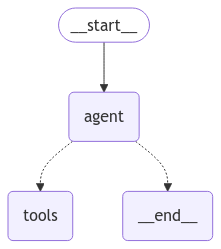

In [24]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

app = workflow.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
app.invoke({"messages": ["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='1f4b3a96-551c-47a8-9cac-ca337afc5e1d'),
  AIMessage(content='I am doing well, thank you for asking. How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-2cd45c5a-ad85-4162-acbc-f49968400c1e-0', usage_metadata={'input_tokens': 14, 'output_tokens': 18, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}})]}

In [26]:
app.invoke({"messages": ["what is the weather in sf"]})

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='aa19c078-922c-438f-b127-624af50ab278'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in sf"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-0f05aa82-9db6-45a6-bb0c-568697a97636-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': '64d316cf-5f00-40bb-a7d6-344d7f6a2c5d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 15, 'output_tokens': 5, 'total_tokens': 20, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="It's 60 degrees and foggy.", name='search', id='232bc793-bcbd-4b66-bb66-55e8941613ca', tool_call_id='64d316cf-5f00-40bb-a7d6-344d7f6a2c5d')]}

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


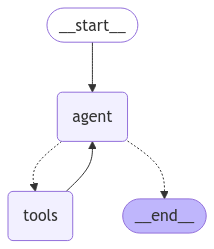

In [28]:
workflow.add_edge("tools", 'agent')

app = workflow.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [29]:
for output in app.stream({"messages": ["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in sf"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d583938b-8333-4726-9c74-adbcfc86baf8-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'faced75f-955b-4147-8614-71ec44fdc291', 'type': 'tool_call'}], usage_metadata={'input_tokens': 15, 'output_tokens': 5, 'total_tokens': 20, 'input_token_details': {'cache_read': 0}})]}


here is output from tools
_______
{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='search', id='c6638bb2-321c-4f4f-a31a-fcc413ff2e98', tool_call_id='faced75f-955b-4147-8614-71ec44fdc291')]}


here is output from agent
_______
{'messages': [AIMessage(content="It's 60 degrees and foggy.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'saf

## Memory

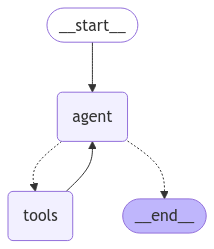

In [30]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Define a new graph
workflow3 = StateGraph(MessagesState)

workflow3.add_node("agent", call_model)
workflow3.add_node("tools", tool_node)

workflow3.add_edge(START, "agent")

workflow3.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

workflow3.add_edge("tools", 'agent')


app3 = workflow3.compile(checkpointer = memory)

from IPython.display import Image, display

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [31]:
config = {"configurable": {"thread_id": "1"}}

events = app3.stream(
    {"messages": ["Hi there! My name is Sunny."]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Sunny.
================================== Ai Message ==================================

Hello Sunny! How can I help you today?


In [33]:
events = app3.stream(
    {"messages": ["can you tell me what was my name?"]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you tell me what was my name?
================================== Ai Message ==================================

Your name is Sunny.


In [34]:
memory.get(config)

{'v': 1,
 'ts': '2025-02-26T20:53:41.423657+00:00',
 'id': '1eff483c-2955-6f16-8004-a344ff83296d',
 'channel_values': {'messages': [HumanMessage(content='Hi there! My name is Sunny.', additional_kwargs={}, response_metadata={}, id='83e30adf-fe21-4118-91ab-00cdd9e1cdae'),
   AIMessage(content='Hello Sunny! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-9c824565-af25-4487-8ecd-5df6f1c87bde-0', usage_metadata={'input_tokens': 17, 'output_tokens': 11, 'total_tokens': 28, 'input_token_details': {'cache_read': 0}}),
   HumanMessage(content='can you tell me what was my name?', additional_kwargs={}, response_metadata={}, id='22b17c0e-bc67-4aa2-b1dd-60f2bf85ab07'),
   AIMessage(content='Your name is Sunny.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, 